In [ ]:
#@title　ドライブマウント＆ライブラリのインストール
from google.colab import drive
drive.mount('/content/drive')

!pip install janome openpyxl pandas -q
!pip install -U sentence-transformers scikit-learn -q

# ライブラリ読み込み
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from janome.tokenizer import Tokenizer
from google.colab import files
import numpy as np

# matplotlib日本語化モジュールをまず実行環境にインストールする。
!pip install japanize-matplotlib
import japanize_matplotlib

from collections import Counter
from janome.analyzer import Analyzer
from janome.tokenfilter import POSKeepFilter

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm


!pip install janome networkx matplotlib
from janome.tokenizer import Tokenizer
import itertools
import networkx as nx

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title
# データの読み込み
file_path = '/content/drive/MyDrive/Colab Notebooks/GCI2025Summer週次アンケートまとめ.xlsx'
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/GCI2025Summer週次アンケートまとめ.xlsx')

# （任意）本日の講義で特によかった部分について、具体的にお教えください。

In [ ]:
#@title 有効回答数

df = pd.read_excel(file_path, usecols='AA')
original_column_name1 = df.columns[0]  # 元の列名を保持

# 無意味な回答の除去
def is_meaningful(text):
    if pd.isnull(text): return False
    text = str(text).strip()
    if text == '' or text == '\n': return False
    if re.fullmatch(r'特に(な|有|あ)りません?[。.]?|なし|ないです|ないと思います|無いです', text): return False
    return True

df = df[df[original_column_name1].apply(is_meaningful)].reset_index(drop=True)
print(f"{len(df)}件の有効な回答が残りました")
df.head()


547件の有効な回答が残りました


,（任意）本日の講義で特によかった部分について、具体的にお教えください。
0,データサイエンスとPythonに関する知識は以前からありましたが、断片的で体系化されていない...
1,基礎的なところから学ぶことができた。
2,Pythonの説明が簡潔にされていたところ。
3,これから進めていく上で必要なスキルや知識の速習が用意されていた。
4,要点がコンパクトにまとまっていて、取り組みやすかった。


In [ ]:
#@title #
# 日本語に強い事前学習済モデル
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# 文ベクトル化
embeddings = model.encode(df[original_column_name1].tolist(), show_progress_bar=True)

# クラスタリング（カテゴリ数Kは任意）
k = 5  # 分類数を仮で5に設定（後で調整可）
kmeans = KMeans(n_clusters=k, random_state=42)
df['クラスタ'] = kmeans.fit_predict(embeddings)

# @title
# TF-IDF用の前処理（janomeで形態素解析）
from janome.tokenizer import Tokenizer
tokenizer = Tokenizer(wakati=True)
def preprocess(text):
    return ' '.join(tokenizer.tokenize(str(text)))

df['前処理済'] = df[original_column_name1].apply(preprocess)

# @title
# クラスタごとの文書をまとめる
cluster_docs = df.groupby('クラスタ')['前処理済'].apply(lambda texts: '。'.join(texts)).to_dict()

# TF-IDFベクトル化
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(cluster_docs.values())
feature_names = vectorizer.get_feature_names_out()
# 各クラスタの自動ラベルを生成
cluster_labels = {}
for i, cluster_id in enumerate(cluster_docs.keys()):
    tfidf_scores = X[i].toarray()[0]
    top_words = [word for word, score in sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)[:3]]
    cluster_labels[cluster_id] = "／".join(top_words)

# 自動ラベル列を追加
df['自動ラベル'] = df['クラスタ'].map(cluster_labels)


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
#@title 各クラスタの代表的な回答（中心に近い3件）
from sklearn.metrics.pairwise import cosine_distances

print("\n=== 各クラスタの代表的な回答（中心に近い3件） ===")

# 各クラスタごとに代表的な回答を表示
for i in range(k):
    print(f"\n--- クラスタ {i}｜ラベル: {cluster_labels[i]} ---")

    # クラスタiに属するインデックス
    cluster_indices = df[df['クラスタ'] == i].index
    cluster_vectors = embeddings[cluster_indices]  # 文ベクトル

    # クラスタ中心とのコサイン距離を計算
    center = kmeans.cluster_centers_[i].reshape(1, -1)
    distances = cosine_distances(cluster_vectors, center).flatten()

    # 中心に近い順に上位3件を取得
    top3_idx_in_cluster = cluster_indices[np.argsort(distances)[:3]]

    for j, idx in enumerate(top3_idx_in_cluster):
        print(f"{j+1}. {df.loc[idx, original_column_name1]}")


=== 各クラスタの代表的な回答（中心に近い3件） ===

--- クラスタ 0｜ラベル: こと／でき／理解 ---
1. 他講座などで学習済みの内容でしたが、よい復習になりました。どのテーマにおいても平易な表現で説明していただきとてもわかりやすかったです。
2. 動画付きオンデマンド講義で、自分のペースで学習することが出来た点、また体系的によくまとまっていた点。理解度チェックも役立ったと感じた。
3. 習ったことのある内容が多かったが、説明が分かりやすくとても良かった。演習で自分で書いてみる時間もあったので、理解度も認識ができた。

--- クラスタ 1｜ラベル: こと／でき／です ---
1. 平易な表現で初学者にもわかりやすく、理解しやすく飽きないちょうどいいペースで進んでいた
2. 図も説明もわかりやすかった。これからの学びの道筋が示されたことで是が非でもくらいついて終了しようという気持ちになった
3. 分かりやすい例で説明していて、頭に残りやすかった。

--- クラスタ 2｜ラベル: データ／サイエンス／こと ---
1. データサイエンスを学ぶ意義やそのほか必要であろう能力の説明が丁寧にしていただきわかりやすかった点
2. そもそもデータサイエンスとはどんなものなのかについてわかりやすく身近な事例から取り上げて説明されているのがとてもイメージがしやすく良かったです。そもそも今学ぼうとしている技術が一体どんな場面で役に立っているのかをより具体的に知識として落としこむことでこの後の講義でより理解しやすい形で消化できると思いました。
3. 今まであやふやだったデータサイエンスとは何かという部分について画一的に理解できてよかったです．資料もわかりやすくありがたかったです．

--- クラスタ 3｜ラベル: python／こと／でき ---
1. 基本的な部分からPythonの学習ができたところ
2. Pythonの基本的な使い方を素人でもわかるようにしてもらった
3. Pythonの基礎について網羅的に復習できたこと。

--- クラスタ 4｜ラベル: やすかっ／スライド／理解 ---
1. スライドに簡潔にまとまっているので、スムーズに理解できた。例題で理解度を確認できるのもよかった。
2. 内容がすごく簡単に初心者にもわかりやすく説明されていた。またグ

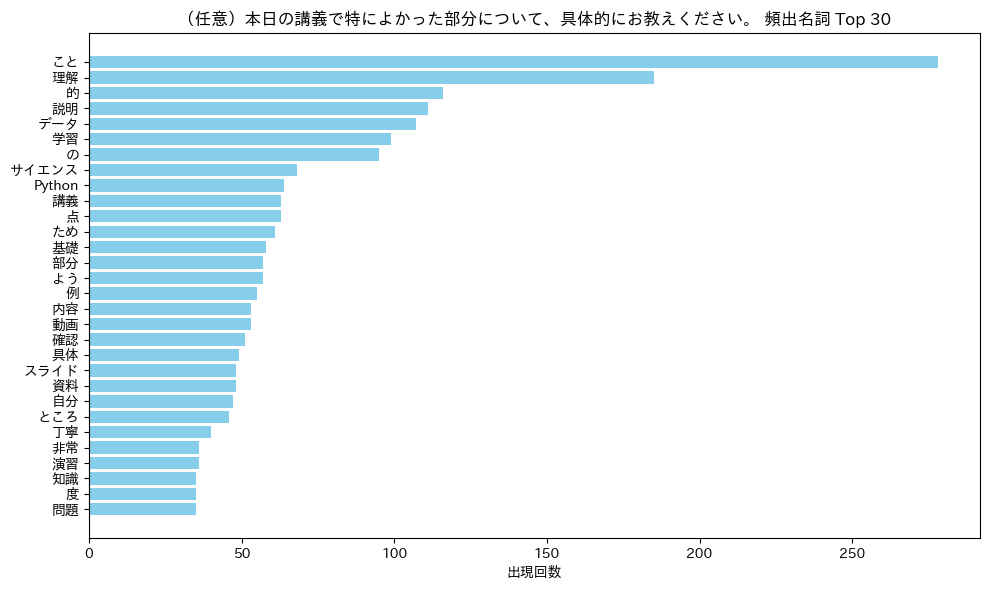

In [ ]:
#@title 頻出名詞Top30
# AA列だけを読み込み（ヘッダ名は保持）
df = pd.read_excel(file_path, usecols='AA')
original_column_name1 = df.columns[0]

# JanomeのAnalyzerを使って「名詞」だけを抽出
a = Analyzer(token_filters=[POSKeepFilter(['名詞'])])

# 名詞のリストを抽出
all_nouns = []
for text in df[original_column_name1].dropna():
    tokens = a.analyze(str(text))
    all_nouns.extend([token.surface for token in tokens])

# 出現回数カウント
word_counts = Counter(all_nouns)

# 上位n語を取得
top_n = 30
most_common = word_counts.most_common(top_n)

# 棒グラフ描画
words, counts = zip(*most_common)
plt.figure(figsize=(10, 6))
plt.barh(words[::-1], counts[::-1], color='skyblue')
plt.xlabel('出現回数')
plt.title(f'{original_column_name1} 頻出名詞 Top {top_n}')
plt.tight_layout()
plt.show()

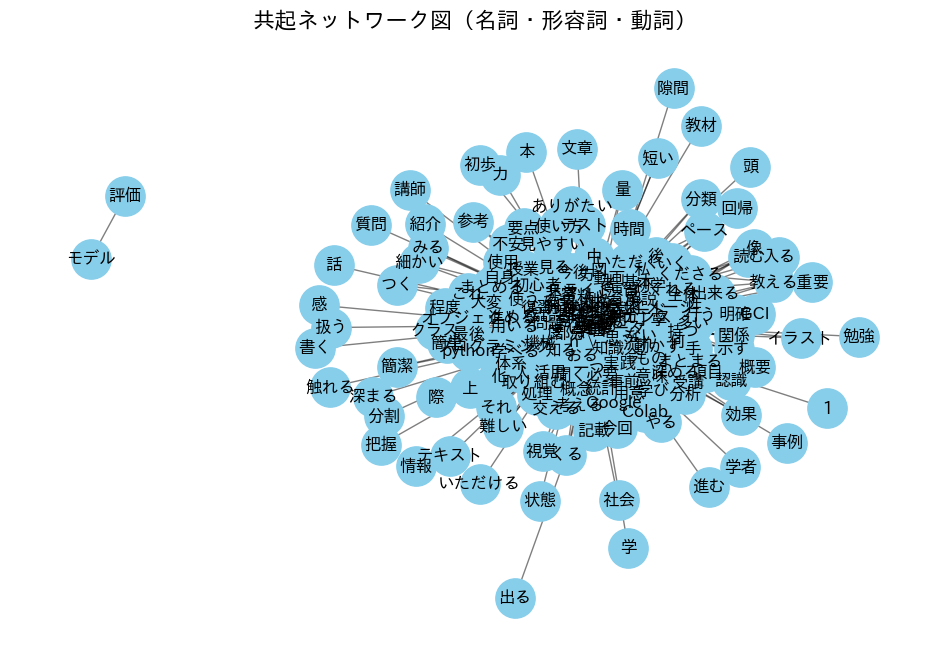

In [ ]:
#@title 共起ネットワーク図

# データ読み込み（カラム名 'text' に自由記述がある前提）
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/GCI2025Summer週次アンケートまとめ.xlsx')

# 形態素解析器
tokenizer = Tokenizer()

# 共起カウント
co_occurrence = Counter()
word_list = []

# テキストごとに処理
# Replacing 'text' with original_column_name1 to access the correct column
for sentence in df[original_column_name1].dropna():
    # 名詞・動詞・形容詞のみ抽出し、原形に変換
    tokens = [token.base_form for token in tokenizer.tokenize(sentence)
              if token.part_of_speech.startswith(("名詞", "形容詞", "動詞"))]
    word_list.append(tokens)

    # 重複を避けた組み合わせ
    for w1, w2 in itertools.combinations(set(tokens), 2):
        pair = tuple(sorted([w1, w2]))
        co_occurrence[pair] += 1

# 共起頻度のしきい値（例：5回以上）
edges = [(w1, w2, freq) for (w1, w2), freq in co_occurrence.items() if freq >= 5]

# グラフ構築
G = nx.Graph()
G.add_weighted_edges_from(edges)

# ネットワーク可視化
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_family="IPAexGothic", font_size=12)
plt.title("共起ネットワーク図（名詞・形容詞・動詞）", fontsize=16)
plt.axis('off')
plt.show()


# （任意）分かりにくかった部分や改善点などがあれば、具体的にお教えください。

In [ ]:
#@title　有効回答数
df = pd.read_excel(file_path, usecols='AB')
original_column_name2 = df.columns[0]  # 元の列名を保持

# 無意味な回答の除去
def is_meaningful(text):
    if pd.isnull(text): return False
    text = str(text).strip()
    if text == '' or text == '\n': return False
    if re.fullmatch(r'特に(な|有|あ)りません?[。.]?|なし|ないです|ないと思います|無いです', text): return False
    return True

df = df[df[original_column_name2].apply(is_meaningful)].reset_index(drop=True)
print(f"{len(df)}件の有効な回答が残りました")
df.head()


266件の有効な回答が残りました


,（任意）分かりにくかった部分や改善点などがあれば、具体的にお教えください。
0,モデル構築②モデルの選択について理解するのに時間がかかった。まず、どういった選択肢がある中か...
1,条件分岐や関数の使い方について、もう少し具体的な例や演習問題があるとさらに理解しやすいと感じ...
2,特にない
3,特になし
4,Pythonのクラス，ライブラリの部分がよくわからなかった．具体的な使用例と各行で何が起こ...


In [ ]:
# @title #
# 日本語に強い事前学習済モデル
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# 文ベクトル化
embeddings = model.encode(df[original_column_name2].tolist(), show_progress_bar=True)

# クラスタリング（カテゴリ数Kは任意）
k = 5  # 分類数を仮で5に設定（後で調整可）
kmeans = KMeans(n_clusters=k, random_state=42)
df['クラスタ'] = kmeans.fit_predict(embeddings)

# TF-IDF用の前処理（janomeで形態素解析）
from janome.tokenizer import Tokenizer
tokenizer = Tokenizer(wakati=True)
def preprocess(text):
    return ' '.join(tokenizer.tokenize(str(text)))

df['前処理済'] = df[original_column_name2].apply(preprocess)

# クラスタごとの文書をまとめる
cluster_docs = df.groupby('クラスタ')['前処理済'].apply(lambda texts: '。'.join(texts)).to_dict()


# TF-IDFベクトル化
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(cluster_docs.values())
feature_names = vectorizer.get_feature_names_out()

# 各クラスタの自動ラベルを生成
cluster_labels = {}
for i, cluster_id in enumerate(cluster_docs.keys()):
    tfidf_scores = X[i].toarray()[0]
    top_words = [word for word, score in sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)[:3]]
    cluster_labels[cluster_id] = "／".join(top_words)

# 自動ラベル列を追加
df['自動ラベル'] = df['クラスタ'].map(cluster_labels)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
#@title 各クラスタの代表的な回答（中心に近い3件）

print("\n=== 各クラスタの代表的な回答（中心に近い3件） ===")
# 各クラスタごとに代表的な回答を表示
for i in range(k):
    print(f"\n--- クラスタ {i}｜ラベル: {cluster_labels[i]} ---")

    # クラスタiに属するインデックス
    cluster_indices = df[df['クラスタ'] == i].index
    cluster_vectors = embeddings[cluster_indices]  # 文ベクトル

    # クラスタ中心とのコサイン距離を計算
    center = kmeans.cluster_centers_[i].reshape(1, -1)
    distances = cosine_distances(cluster_vectors, center).flatten()

    # 中心に近い順に上位3件を取得
    top3_idx_in_cluster = cluster_indices[np.argsort(distances)[:3]]

    for j, idx in enumerate(top3_idx_in_cluster):
        print(f"{j+1}. {df.loc[idx, original_column_name2]}")



=== 各クラスタの代表的な回答（中心に近い3件） ===

--- クラスタ 0｜ラベル: 音声／動画／ない ---
1. ・仕方ないかもしれないが，各動画の間に広告が入ること．\n・動画の音圧が小さいと感じた．→広告時に音が大きくなり，ちょっと不快感だった．（こちらの環境の可能性もあり）
2. 動画音声が小さく広告での音声と差がありすぎた。
3. 動画によって音量レベルが違いすぎて不便

--- クラスタ 1｜ラベル: 特に／なし／ない ---
1. 特にない
2. 特にございません
3. 特にないです

--- クラスタ 2｜ラベル: まし／理解／なかっ ---
1. NotionやSlack, その他ツールは使い慣れている方ですが重複もあって少し読みにくかった（理解しにくかった）と感じました。\n全部の情報を網羅出来ているか不安になりました。
2. 最初の設定部分が説明書が何枚もあり大変でした
3. リストや関数、メソッド、オブジェクトなどの概念を理解するのに時間がかかり難しいと感じた。

--- クラスタ 3｜ラベル: python／オブジェクト／クラス ---
1. Pythonの基礎と概要の項目で、オブジェクトとクラスの項目が個人的に分かりづらかったかなと思いますが、わかりやすくしようとすると逆に理解しづらくなってしまうと思うのでなんとも言えません。
2. Pythonのオブジェクトとクラスに関する説明が少し理解しづらかった。
3. python基礎のオブジェクトとクラスの話がいまいちよく分からなかった。それと、教師あり学習の回帰と分類の話も分からなかった。

--- クラスタ 4｜ラベル: ある／ます／ので ---
1. 関数に関する説明が少ないように感じたが，自分でsklearnのホームページから知りたい関数の内容について勉強できたので，教わるよりも効率的に学習できたように感じた
2. まだ理解できないかもしれないが、参考として具体例のモデルを作った際のプログラムの一部があると、個人的にはこれから学ぶ内容にワクワクする気がした。
3. オブジェクトとクラス、ライブラリの部分が情報量が多く、理解が追い付いていない。練習問題などを追加してもらえると理解が進むと思う。


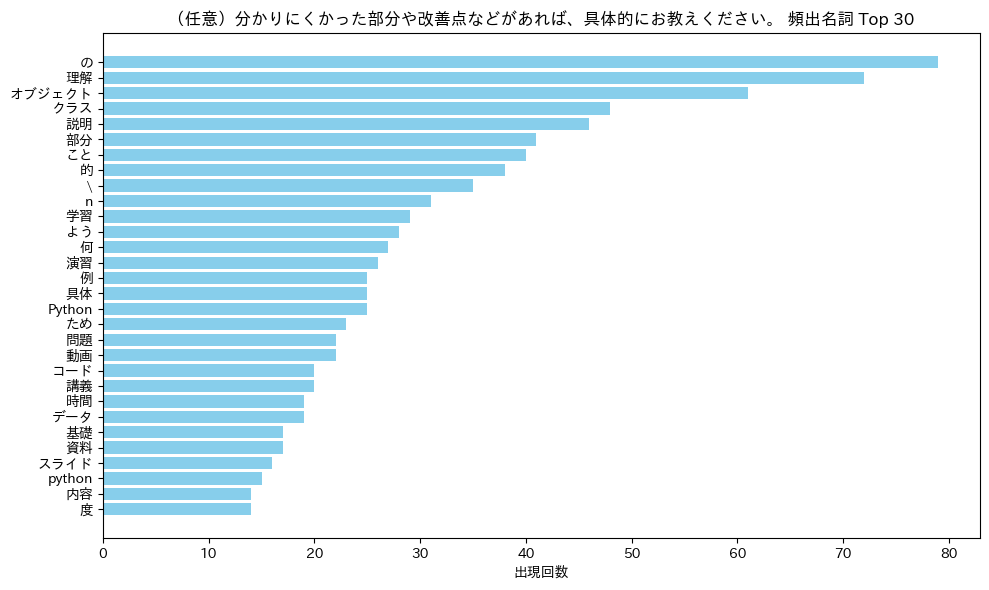

In [ ]:
#@title 頻出名詞Top30
# AB列だけを読み込み（ヘッダ名は保持）
df = pd.read_excel(file_path, usecols='AB')
original_column_name2 = df.columns[0]

# JanomeのAnalyzerを使って「名詞」だけを抽出
a = Analyzer(token_filters=[POSKeepFilter(['名詞'])])

# 名詞のリストを抽出
all_nouns = []
for text in df[original_column_name2].dropna():
    tokens = a.analyze(str(text))
    all_nouns.extend([token.surface for token in tokens])

# 出現回数カウント
word_counts = Counter(all_nouns)

# 上位n語を取得
top_n = 30
most_common = word_counts.most_common(top_n)

# 棒グラフ描画
words, counts = zip(*most_common)
plt.figure(figsize=(10, 6))
plt.barh(words[::-1], counts[::-1], color='skyblue')
plt.xlabel('出現回数')
plt.title(f'{original_column_name2} 頻出名詞 Top {top_n}')
plt.tight_layout()
plt.show()

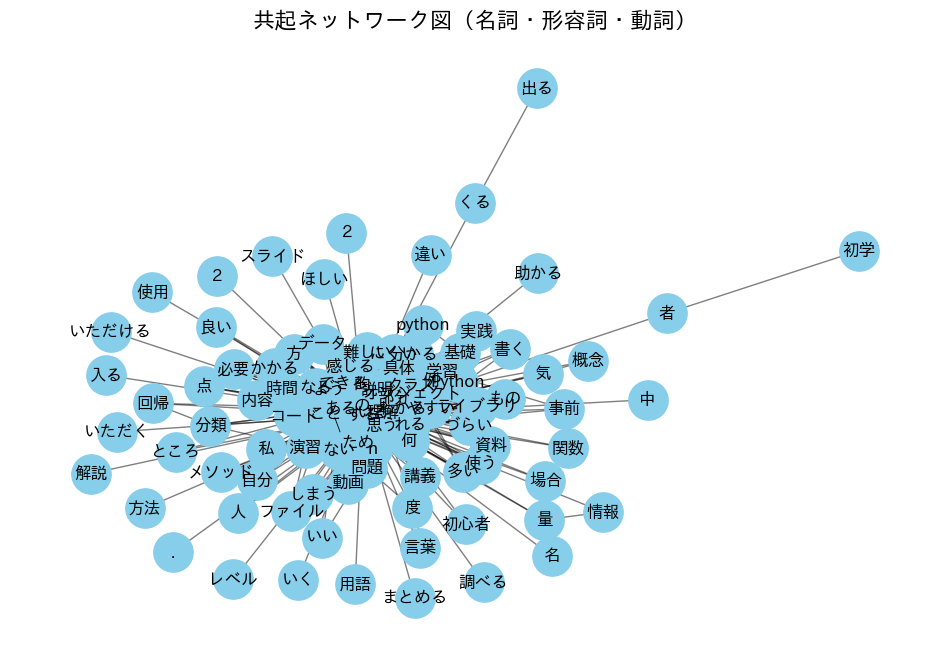

In [ ]:
#@title　共起ネットワーク図
# データ読み込み（カラム名 'text' に自由記述がある前提）
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/GCI2025Summer週次アンケートまとめ.xlsx')

# 形態素解析器
tokenizer = Tokenizer()

# 共起カウント
co_occurrence = Counter()
word_list = []

# テキストごとに処理
# Replacing 'text' with original_column_name2 to access the correct column
for sentence in df[original_column_name2].dropna():
    # 名詞・動詞・形容詞のみ抽出し、原形に変換
    tokens = [token.base_form for token in tokenizer.tokenize(sentence)
              if token.part_of_speech.startswith(("名詞", "形容詞", "動詞"))]
    word_list.append(tokens)

    # 重複を避けた組み合わせ
    for w1, w2 in itertools.combinations(set(tokens), 2):
        pair = tuple(sorted([w1, w2]))
        co_occurrence[pair] += 1

# 共起頻度のしきい値（例：5回以上）
edges = [(w1, w2, freq) for (w1, w2), freq in co_occurrence.items() if freq >= 5]

# グラフ構築
G = nx.Graph()
G.add_weighted_edges_from(edges)

# ネットワーク可視化
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_family="IPAexGothic", font_size=12)
plt.title("共起ネットワーク図（名詞・形容詞・動詞）", fontsize=16)
plt.axis('off')
plt.show()


# （任意）講師について、よかった点や不満があった点などについて、具体的にお教えください。`

In [ ]:
#@title　有効回答数
df = pd.read_excel(file_path, usecols='AC')
original_column_name3 = df.columns[0]  # 元の列名を保持

# 無意味な回答の除去
def is_meaningful(text):
    if pd.isnull(text): return False
    text = str(text).strip()
    if text == '' or text == '\n': return False
    if re.fullmatch(r'特に(な|有|あ)りません?[。.]?|なし|ないです|ないと思います|無いです', text): return False
    return True

df = df[df[original_column_name3].apply(is_meaningful)].reset_index(drop=True)
print(f"{len(df)}件の有効な回答が残りました")
df.head()


158件の有効な回答が残りました


,（任意）講師について、よかった点や不満があった点などについて、具体的にお教えください。
0,講師の説明が丁寧で、質問にも分かりやすく答えてくださった点が良かったです。専門用語もかみ砕い...
1,話すスピードも声も聴き取りやすかった。
2,特になし
3,演習は実際にやってみたが、事前学習では演習まで含まれているのかよく分からなかった。
4,男性講師の声が聞き取りにくい。


In [ ]:
#@title #
# 日本語に強い事前学習済モデル
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# 文ベクトル化
embeddings = model.encode(df[original_column_name3].tolist(), show_progress_bar=True)

# クラスタリング（カテゴリ数Kは任意）
k = 5  # 分類数を仮で5に設定（後で調整可）
kmeans = KMeans(n_clusters=k, random_state=42)
df['クラスタ'] = kmeans.fit_predict(embeddings)

# TF-IDF用の前処理（janomeで形態素解析）
from janome.tokenizer import Tokenizer
tokenizer = Tokenizer(wakati=True)
def preprocess(text):
    return ' '.join(tokenizer.tokenize(str(text)))

df['前処理済'] = df[original_column_name3].apply(preprocess)

# クラスタごとの文書をまとめる
cluster_docs = df.groupby('クラスタ')['前処理済'].apply(lambda texts: '。'.join(texts)).to_dict()


# TF-IDFベクトル化
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(cluster_docs.values())
feature_names = vectorizer.get_feature_names_out()

# 各クラスタの自動ラベルを生成
cluster_labels = {}
for i, cluster_id in enumerate(cluster_docs.keys()):
    tfidf_scores = X[i].toarray()[0]
    top_words = [word for word, score in sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)[:3]]
    cluster_labels[cluster_id] = "／".join(top_words)

# 自動ラベル列を追加
df['自動ラベル'] = df['クラスタ'].map(cluster_labels)




Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#@title 各クラスタの代表的な回答（中心に近い3件）
print("\n=== 各クラスタの代表的な回答（中心に近い3件） ===")

# 各クラスタごとに代表的な回答を表示
for i in range(k):
    print(f"\n--- クラスタ {i}｜ラベル: {cluster_labels[i]} ---")

    # クラスタiに属するインデックス
    cluster_indices = df[df['クラスタ'] == i].index
    cluster_vectors = embeddings[cluster_indices]  # 文ベクトル

    # クラスタ中心とのコサイン距離を計算
    center = kmeans.cluster_centers_[i].reshape(1, -1)
    distances = cosine_distances(cluster_vectors, center).flatten()

    # 中心に近い順に上位3件を取得
    top3_idx_in_cluster = cluster_indices[np.argsort(distances)[:3]]

    for j, idx in enumerate(top3_idx_in_cluster):
        print(f"{j+1}. {df.loc[idx, original_column_name3]}")



=== 各クラスタの代表的な回答（中心に近い3件） ===

--- クラスタ 0｜ラベル: まし／学習／理解 ---
1. 講師の方の説明が、初めて聞く用語が多いと一息に説明される文章がそんなに長くなくても何回も聞かないとわからない。また、聞き取れてもその意味を理解するのに時間がかかった（もちろん私の能力によるものだとは自負しています）。
2. 講師の説明はとても丁寧で、内容も興味深く、学習意欲が高まりました。ただ、講義のスピードがやや速く、もう少し要点を区切りながら進めていただけると、より理解しやすかったと思います。
3. リアルな人間の講義なので仕方がないと思うが、講師の鼻すすり音などが気になった。

--- クラスタ 1｜ラベル: おり／解説／とても ---
1. 楽しそうに解説されており、よかった。
2. 素晴らしいです
3. イメージの湧きやすい図解がとても気に入った。

--- クラスタ 2｜ラベル: 説明／わかり／です ---
1. 分かりやすく丁寧に解説してくださった点が、良かったです。
2. みなさんとてもご説明がうまく、すごくわかりやすかったです。
3. 全体的に非常にわかりやすかったです。ありがとうございます。

--- クラスタ 3｜ラベル: やすかっ／聞き取り／やすく ---
1. 聞き取りやすい話し方であった点が良かった。
2. 話し方が明瞭で聞き取りやすかった。
3. 話し声がとても聞きやすかったです。

--- クラスタ 4｜ラベル: なし／特に／ない ---
1. 特になし
2. 特になし
3. 特になし


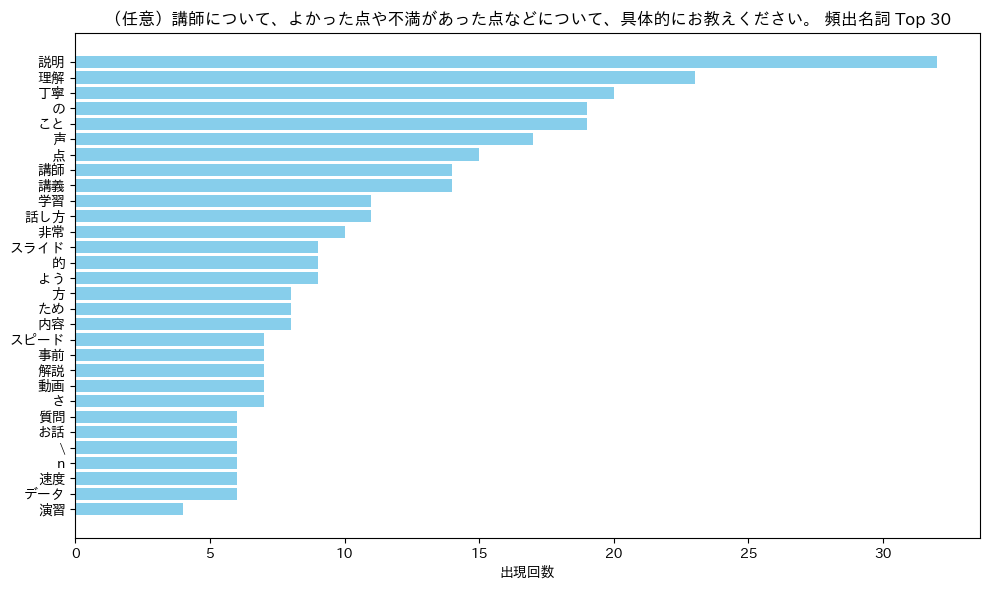

In [ ]:
#@title 頻出名詞Top30
# AC列だけを読み込み（ヘッダ名は保持）
df = pd.read_excel(file_path, usecols='AC')
original_column_name3 = df.columns[0]

# JanomeのAnalyzerを使って「名詞」だけを抽出
a = Analyzer(token_filters=[POSKeepFilter(['名詞'])])

# 名詞のリストを抽出
all_nouns = []
for text in df[original_column_name3].dropna():
    tokens = a.analyze(str(text))
    all_nouns.extend([token.surface for token in tokens])

# 出現回数カウント
word_counts = Counter(all_nouns)

# 上位n語を取得
top_n = 30
most_common = word_counts.most_common(top_n)

# 棒グラフ描画
words, counts = zip(*most_common)
plt.figure(figsize=(10, 6))
plt.barh(words[::-1], counts[::-1], color='skyblue')
plt.xlabel('出現回数')
plt.title(f'{original_column_name3} 頻出名詞 Top {top_n}')
plt.tight_layout()
plt.show()

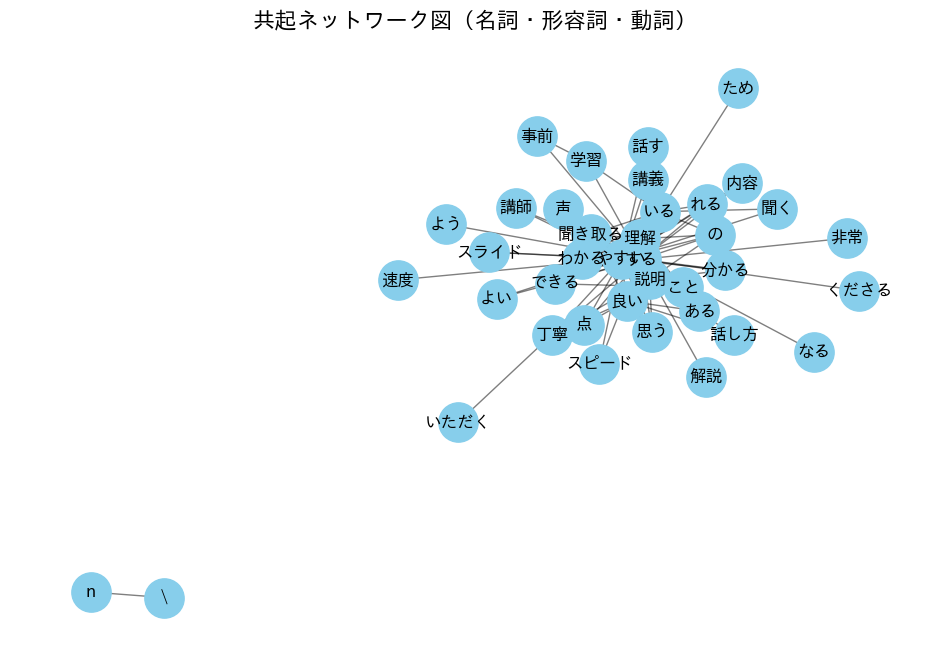

In [ ]:
#@title　共起ネットワーク図
# データ読み込み（カラム名 'text' に自由記述がある前提）
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/GCI2025Summer週次アンケートまとめ.xlsx')

# 形態素解析器
tokenizer = Tokenizer()

# 共起カウント
co_occurrence = Counter()
word_list = []

# テキストごとに処理
# Replacing 'text' with original_column_name3 to access the correct column
for sentence in df[original_column_name3].dropna():
    # 名詞・動詞・形容詞のみ抽出し、原形に変換
    tokens = [token.base_form for token in tokenizer.tokenize(sentence)
              if token.part_of_speech.startswith(("名詞", "形容詞", "動詞"))]
    word_list.append(tokens)

    # 重複を避けた組み合わせ
    for w1, w2 in itertools.combinations(set(tokens), 2):
        pair = tuple(sorted([w1, w2]))
        co_occurrence[pair] += 1

# 共起頻度のしきい値（例：5回以上）
edges = [(w1, w2, freq) for (w1, w2), freq in co_occurrence.items() if freq >= 5]

# グラフ構築
G = nx.Graph()
G.add_weighted_edges_from(edges)

# ネットワーク可視化
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_family="IPAexGothic", font_size=12)
plt.title("共起ネットワーク図（名詞・形容詞・動詞）", fontsize=16)
plt.axis('off')
plt.show()


# （任意）今後開講してほしい講義・分野などがあればお書きください。

In [ ]:
#@title　有効回答数
df = pd.read_excel(file_path, usecols='AD')
original_column_name4 = df.columns[0]  # 元の列名を保持

# 無意味な回答の除去
def is_meaningful(text):
    if pd.isnull(text): return False
    text = str(text).strip()
    if text == '' or text == '\n': return False
    if re.fullmatch(r'特に(な|有|あ)りません?[。.]?|なし|ないです|ないと思います|無いです', text): return False
    return True

df = df[df[original_column_name4].apply(is_meaningful)].reset_index(drop=True)
print(f"{len(df)}件の有効な回答が残りました")
df.head()


120件の有効な回答が残りました


,（任意）今後開講してほしい講義・分野などがあればお書きください。
0,機械学習の原理及び手法、実践
1,まだ学びたてなのでわからないが、実践問題だけを扱う動画を出してもらえたら予習復習に役立つと思った。
2,Pythonの基礎について、クイックに実践できる講座があるとありがたいと感じました。
3,プログラミングにおける生成AIの上手な取り入れ方を教えていただきたいです。
4,機械学習の演習


In [ ]:
#@title #
# 日本語に強い事前学習済モデル
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# 文ベクトル化
embeddings = model.encode(df[original_column_name4].tolist(), show_progress_bar=True)

# クラスタリング（カテゴリ数Kは任意）
k = 5  # 分類数を仮で5に設定（後で調整可）
kmeans = KMeans(n_clusters=k, random_state=42)
df['クラスタ'] = kmeans.fit_predict(embeddings)

# TF-IDF用の前処理（janomeで形態素解析）
from janome.tokenizer import Tokenizer
tokenizer = Tokenizer(wakati=True)
def preprocess(text):
    return ' '.join(tokenizer.tokenize(str(text)))

df['前処理済'] = df[original_column_name4].apply(preprocess)

# クラスタごとの文書をまとめる
cluster_docs = df.groupby('クラスタ')['前処理済'].apply(lambda texts: '。'.join(texts)).to_dict()


# TF-IDFベクトル化
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(cluster_docs.values())
feature_names = vectorizer.get_feature_names_out()

# 各クラスタの自動ラベルを生成
cluster_labels = {}
for i, cluster_id in enumerate(cluster_docs.keys()):
    tfidf_scores = X[i].toarray()[0]
    top_words = [word for word, score in sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)[:3]]
    cluster_labels[cluster_id] = "／".join(top_words)

# 自動ラベル列を追加
df['自動ラベル'] = df['クラスタ'].map(cluster_labels)



Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#@title 各クラスタの代表的な回答（中心に近い3件）
print("\n=== 各クラスタの代表的な回答（中心に近い3件） ===")

# 各クラスタごとに代表的な回答を表示
for i in range(k):
    print(f"\n--- クラスタ {i}｜ラベル: {cluster_labels[i]} ---")

    # クラスタiに属するインデックス
    cluster_indices = df[df['クラスタ'] == i].index
    cluster_vectors = embeddings[cluster_indices]  # 文ベクトル

    # クラスタ中心とのコサイン距離を計算
    center = kmeans.cluster_centers_[i].reshape(1, -1)
    distances = cosine_distances(cluster_vectors, center).flatten()

    # 中心に近い順に上位3件を取得
    top3_idx_in_cluster = cluster_indices[np.argsort(distances)[:3]]

    for j, idx in enumerate(top3_idx_in_cluster):
        print(f"{j+1}. {df.loc[idx, original_column_name4]}")



=== 各クラスタの代表的な回答（中心に近い3件） ===

--- クラスタ 0｜ラベル: データ／統計／処理 ---
1. 医療系のビックデータの扱い方や、データサイエンティストについて具体的にきいてみたい
2. 統計はもう少し専門的なことも学んでみたいと思った。
3. 最新のデータサイエンスの研究動向などの講義（講演）があればぜひ参加させていただきたい。

--- クラスタ 1｜ラベル: ai／です／分野 ---
1. Generative AIなど
2. AIと心理学の複合分野
3. プログラミングにおける生成AIの上手な取り入れ方を教えていただきたいです。

--- クラスタ 2｜ラベル: 講義／かも／ない ---
1. サイバーセキュリティーやホワイトハッカー分野の講義
2. (参議院選挙出馬の可能性があり難しいかもしれないが)安野貴博先生にデジタル民主主義についての講義をしていただきたい。

--- クラスタ 3｜ラベル: 特に／なし／ませ ---
1. 今のところ特になし
2. 今のところなし
3. 今のところなし。

--- クラスタ 4｜ラベル: です／たい／講座 ---
1. 既にありますが、AIアルゴリズムについて、初学者でも分かるように基礎から学べる講義を開講してほしいです。
2. 個人的な希望にはなりますが、ゲームプログラミングにも興味があるので、今後そういった講義も開講していただけたら嬉しいです。今回の講義がとても分かりやすかったので、さらに深く学びたいと感じました。
3. 生成AIについての講義をして欲しいです！


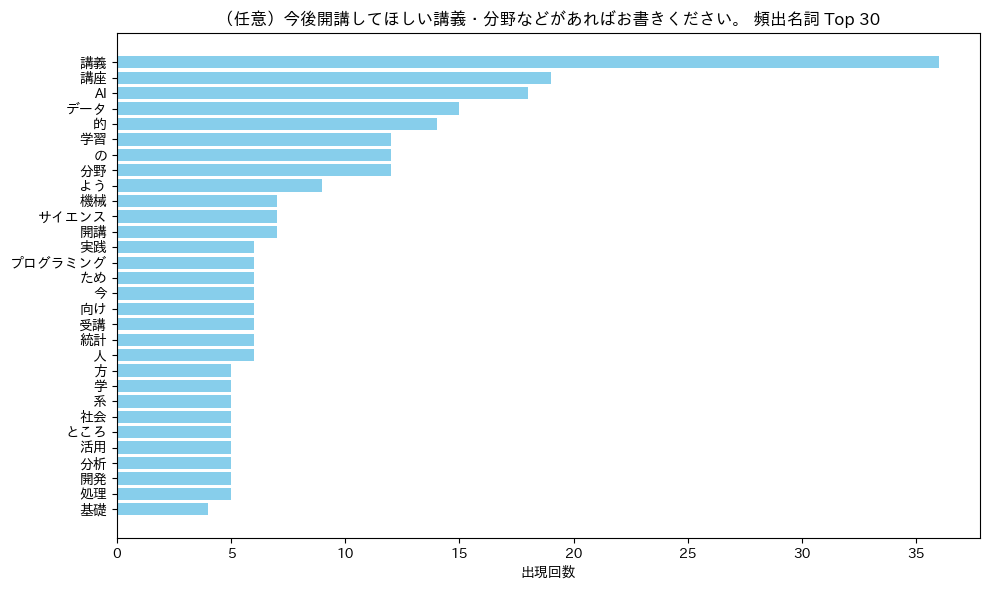

In [ ]:
#@title 頻出名詞Top30
# AC列だけを読み込み（ヘッダ名は保持）
df = pd.read_excel(file_path, usecols='AD')
original_column_name4 = df.columns[0]

# JanomeのAnalyzerを使って「名詞」だけを抽出
a = Analyzer(token_filters=[POSKeepFilter(['名詞'])])

# 名詞のリストを抽出
all_nouns = []
for text in df[original_column_name4].dropna():
    tokens = a.analyze(str(text))
    all_nouns.extend([token.surface for token in tokens])

# 出現回数カウント
word_counts = Counter(all_nouns)

# 上位n語を取得
top_n = 30
most_common = word_counts.most_common(top_n)

# 棒グラフ描画
words, counts = zip(*most_common)
plt.figure(figsize=(10, 6))
plt.barh(words[::-1], counts[::-1], color='skyblue')
plt.xlabel('出現回数')
plt.title(f'{original_column_name4} 頻出名詞 Top {top_n}')
plt.tight_layout()
plt.show()

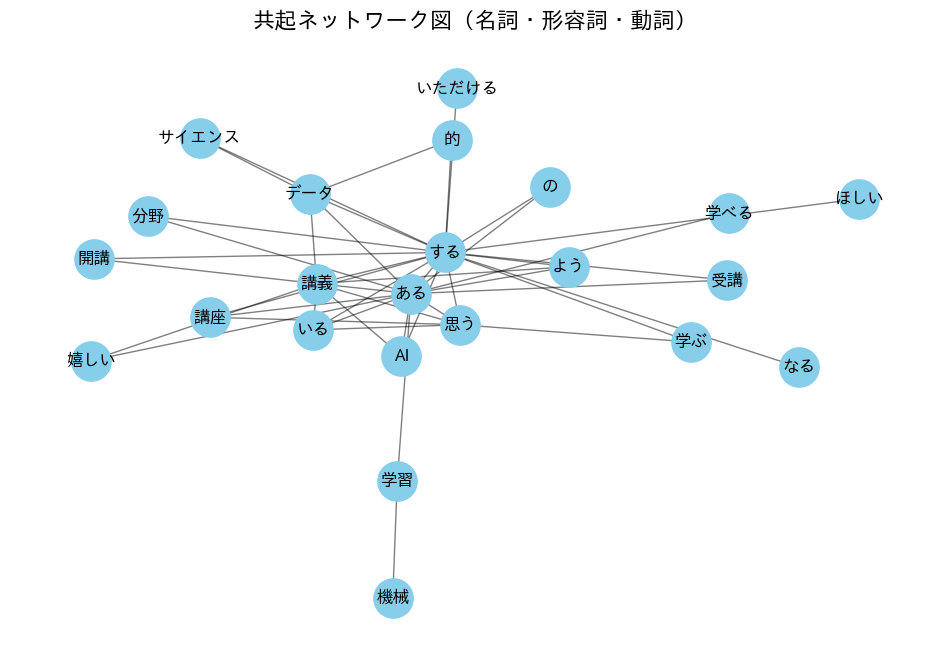

In [ ]:
#@title　共起ネットワーク図
# データ読み込み（カラム名 'text' に自由記述がある前提）
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/GCI2025Summer週次アンケートまとめ.xlsx')

# 形態素解析器
tokenizer = Tokenizer()

# 共起カウント
co_occurrence = Counter()
word_list = []

# テキストごとに処理
# Replacing 'text' with original_column_name4 to access the correct column
for sentence in df[original_column_name4].dropna():
    # 名詞・動詞・形容詞のみ抽出し、原形に変換
    tokens = [token.base_form for token in tokenizer.tokenize(sentence)
              if token.part_of_speech.startswith(("名詞", "形容詞", "動詞"))]
    word_list.append(tokens)

    # 重複を避けた組み合わせ
    for w1, w2 in itertools.combinations(set(tokens), 2):
        pair = tuple(sorted([w1, w2]))
        co_occurrence[pair] += 1

# 共起頻度のしきい値（例：5回以上）
edges = [(w1, w2, freq) for (w1, w2), freq in co_occurrence.items() if freq >= 5]

# グラフ構築
G = nx.Graph()
G.add_weighted_edges_from(edges)

# ネットワーク可視化
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_family="IPAexGothic", font_size=12)
plt.title("共起ネットワーク図（名詞・形容詞・動詞）", fontsize=16)
plt.axis('off')
plt.show()


# （任意）ご自由にご意見をお書きください。

In [ ]:
#@title　有効回答数
df = pd.read_excel(file_path, usecols='AE')
original_column_name5 = df.columns[0]  # 元の列名を保持

# 無意味な回答の除去
def is_meaningful(text):
    if pd.isnull(text): return False
    text = str(text).strip()
    if text == '' or text == '\n': return False
    if re.fullmatch(r'特に(な|有|あ)りません?[。.]?|なし|ないです|ないと思います|無いです', text): return False
    return True

df = df[df[original_column_name5].apply(is_meaningful)].reset_index(drop=True)
print(f"{len(df)}件の有効な回答が残りました")
df.head()


187件の有効な回答が残りました


,（任意）ご自由にご意見をお書きください。
0,最初は事前学習で、知識をインプットしかできないけれど、これからの演習でアウトプットしていき、...
1,学習したことのある範囲もあったが、基礎を復習したり、抜けを確認できたりして良かった。繰り返し...
2,数学の知識が必要かと思ったが現段階では標準偏差や分散などの履修したことのある分野だったので安...
3,学生間で質問しあえる環境を整備していただいて助かります。ありがとうございます。
4,オンラインで自分のペースで学べる環境がとてもありがたいです。今後も、データサイエンスやAI分...


In [ ]:
#@title #
# 日本語に強い事前学習済モデル
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# 文ベクトル化
embeddings = model.encode(df[original_column_name5].tolist(), show_progress_bar=True)

# クラスタリング（カテゴリ数Kは任意）
k = 5  # 分類数を仮で5に設定（後で調整可）
kmeans = KMeans(n_clusters=k, random_state=42)
df['クラスタ'] = kmeans.fit_predict(embeddings)

# TF-IDF用の前処理（janomeで形態素解析）
from janome.tokenizer import Tokenizer
tokenizer = Tokenizer(wakati=True)
def preprocess(text):
    return ' '.join(tokenizer.tokenize(str(text)))

df['前処理済'] = df[original_column_name5].apply(preprocess)

# クラスタごとの文書をまとめる
cluster_docs = df.groupby('クラスタ')['前処理済'].apply(lambda texts: '。'.join(texts)).to_dict()


# TF-IDFベクトル化
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(cluster_docs.values())
feature_names = vectorizer.get_feature_names_out()

# 各クラスタの自動ラベルを生成
cluster_labels = {}
for i, cluster_id in enumerate(cluster_docs.keys()):
    tfidf_scores = X[i].toarray()[0]
    top_words = [word for word, score in sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)[:3]]
    cluster_labels[cluster_id] = "／".join(top_words)

# 自動ラベル列を追加
df['自動ラベル'] = df['クラスタ'].map(cluster_labels)



Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
#@title 各クラスタの代表的な回答（中心に近い3件）
print("\n=== 各クラスタの代表的な回答（中心に近い3件） ===")

# 各クラスタごとに代表的な回答を表示
for i in range(k):
    print(f"\n--- クラスタ {i}｜ラベル: {cluster_labels[i]} ---")

    # クラスタiに属するインデックス
    cluster_indices = df[df['クラスタ'] == i].index
    cluster_vectors = embeddings[cluster_indices]  # 文ベクトル

    # クラスタ中心とのコサイン距離を計算
    center = kmeans.cluster_centers_[i].reshape(1, -1)
    distances = cosine_distances(cluster_vectors, center).flatten()

    # 中心に近い順に上位3件を取得
    top3_idx_in_cluster = cluster_indices[np.argsort(distances)[:3]]

    for j, idx in enumerate(top3_idx_in_cluster):
        print(f"{j+1}. {df.loc[idx, original_column_name5]}")



=== 各クラスタの代表的な回答（中心に近い3件） ===

--- クラスタ 0｜ラベル: 講義／ます／まし ---
1. 次回に向けて、とても意欲の湧く講義でした。ありがとうございました！\n
2. 今回の講義は、非常に多くの要素を学ぶ機会となるため、一つ一つ着実に進めていけたらと思っています。これからよろしくお願いいたします。
3. 今後の講義もよろしくお願いいたします。

--- クラスタ 1｜ラベル: ます／お願い／たい ---
1. これからよろしくお願いします。貴重な学習の機会に参加することができ、幸いです。
2. 初心者になりますが、修了できるように頑張りたいと思いますので、ご指導ご鞭撻のほどよろしくお願いします。
3. 修了を目指して頑張りますので、ご指導ご鞭撻のほど、よろしくお願いいたします。

--- クラスタ 2｜ラベル: ます／お願い／よろしく ---
1. 本番もがんばります
2. よろしくお願いします
3. これからよろしくお願いいたします。

--- クラスタ 3｜ラベル: こと／python／まし ---
1. プログラミング初心者でもわかりやすく説明が書かれていて、とても良い講座だと感じました。
2. 基礎なので既に知っている知識は多かったが、あたらためてPythonの使い方などを復習できた。
3. 初学者でも分かりやすい構成で、理解が深まった。統計、Python全て基礎から学べてよかった。

--- クラスタ 4｜ラベル: 学習／こと／たい ---
1. 学習したことのある範囲もあったが、基礎を復習したり、抜けを確認できたりして良かった。繰り返し見て定着させたい。
2. 事前学習の内容も少しわからないことがあるので、できればより詳しいしりょうがあれば助かります。
3. 導入編の予習から理解すること、覚えていくべき課題がたくさん見えてやりごたえがあった。何回か見てやっと腑に落ちる部分もあったが、今のところは回数を重ねれば理解はできそうなのでこの続きも頑張っていきたい。


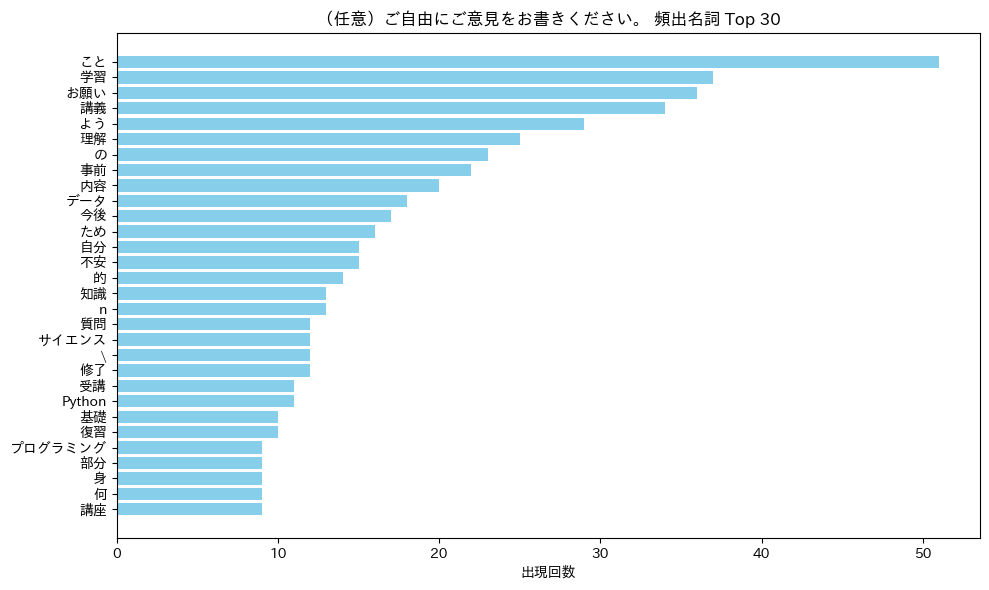

In [ ]:
#@title 頻出名詞Top30
# AE列だけを読み込み（ヘッダ名は保持）
df = pd.read_excel(file_path, usecols='AE')
original_column_name5 = df.columns[0]

# JanomeのAnalyzerを使って「名詞」だけを抽出
a = Analyzer(token_filters=[POSKeepFilter(['名詞'])])

# 名詞のリストを抽出
all_nouns = []
for text in df[original_column_name5].dropna():
    tokens = a.analyze(str(text))
    all_nouns.extend([token.surface for token in tokens])

# 出現回数カウント
word_counts = Counter(all_nouns)

# 上位n語を取得
top_n = 30
most_common = word_counts.most_common(top_n)

# 棒グラフ描画
words, counts = zip(*most_common)
plt.figure(figsize=(10, 6))
plt.barh(words[::-1], counts[::-1], color='skyblue')
plt.xlabel('出現回数')
plt.title(f'{original_column_name5} 頻出名詞 Top {top_n}')
plt.tight_layout()
plt.show()

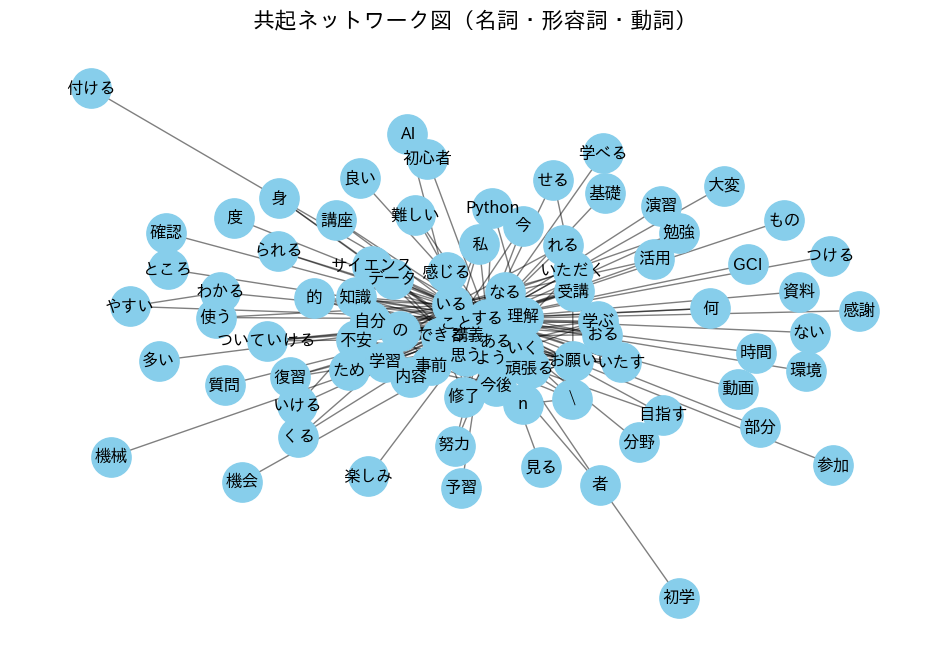

In [ ]:
#@title　共起ネットワーク図
# データ読み込み（カラム名 'text' に自由記述がある前提）
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/GCI2025Summer週次アンケートまとめ.xlsx')

# 形態素解析器
tokenizer = Tokenizer()

# 共起カウント
co_occurrence = Counter()
word_list = []

# テキストごとに処理
# Replacing 'text' with original_column_name5 to access the correct column
for sentence in df[original_column_name5].dropna():
    # 名詞・動詞・形容詞のみ抽出し、原形に変換
    tokens = [token.base_form for token in tokenizer.tokenize(sentence)
              if token.part_of_speech.startswith(("名詞", "形容詞", "動詞"))]
    word_list.append(tokens)

    # 重複を避けた組み合わせ
    for w1, w2 in itertools.combinations(set(tokens), 2):
        pair = tuple(sorted([w1, w2]))
        co_occurrence[pair] += 1

# 共起頻度のしきい値（例：5回以上）
edges = [(w1, w2, freq) for (w1, w2), freq in co_occurrence.items() if freq >= 5]

# グラフ構築
G = nx.Graph()
G.add_weighted_edges_from(edges)

# ネットワーク可視化
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_family="IPAexGothic", font_size=12)
plt.title("共起ネットワーク図（名詞・形容詞・動詞）", fontsize=16)
plt.axis('off')
plt.show()


以上